# MBTI Project

By The Introverts 

In [1]:
reset -fs

In [54]:
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string 
import re
from collections import Counter
import numpy as np
plt.style.use('fivethirtyeight')

## The Data
#### Personality types:
* extroversion vs. introversion
* intuition vs. sensing
* thinking vs. feeling
* judging vs. perceiving


In [6]:
mbti = pd.read_csv('data/mbti_1.csv') # Original Dataframe
# mbti_clean = mbti.copy() # Dataframe to be cleaned 
# mbti_features = mbti.copy() # Dataframe to be populated with features
# #mbti_features.drop(columns=['posts'],inplace=True) ?

## General info:
#### Personality Types:

First, we take a look at distribution of the MBTI personality types

<BarContainer object of 16 artists>

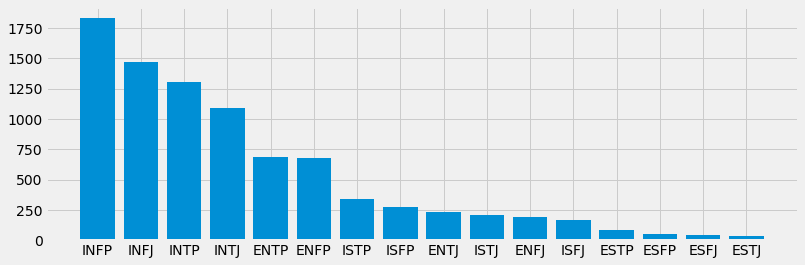

In [7]:
stat = mbti['type'].value_counts()
plt.figure(figsize=(12,4))
plt.bar(stat.index,stat.values)

4 capitals' meaning:
- extroversion vs. introversion 
- intuition vs. sensing
- thinking vs. feeling
- judging vs. perceiving

In [8]:
# Types per category
# analyze types by sub-category may be easier
mbti['EorI']= mbti['type'].apply(lambda x:x[0])
mbti['NorS']= mbti['type'].apply(lambda x:x[1])
mbti['TorF']= mbti['type'].apply(lambda x:x[2])
mbti['JorP']= mbti['type'].apply(lambda x:x[3])

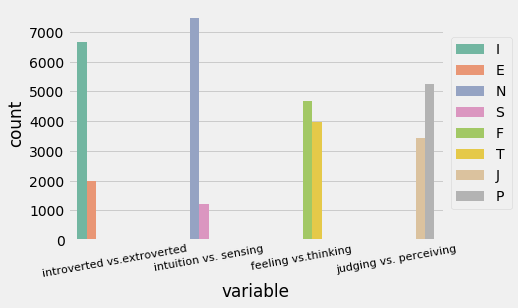

In [9]:
ax = sns.countplot(x='variable',hue='value',data=pd.melt(mbti.iloc[:,2:]),palette="Set2")
ax.set_xticklabels(["introverted vs.extroverted", "intuition vs. sensing", 
                    "feeling vs.thinking ", "judging vs. perceiving", 
                    ], rotation=10, fontsize=11)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Imbalanced class: I vs E, N vs S. Some advanced techniques like resampling methods may be needed later to handle imbalanced classes.

#### Their last 50 posts:
Focus on some statistics(mean,variance) of posts

words they averagely used in per comment

In [10]:
mbti['avg_comment_length'] = mbti['posts'].apply(lambda x: len(x.split())/50)
mbti['comment_length_var'] = mbti['posts'].apply(lambda x: np.var([len(sentence.split()) for sentence in x.split('|||')]))

In [11]:
mbti.head()

,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,19.34,196.4576


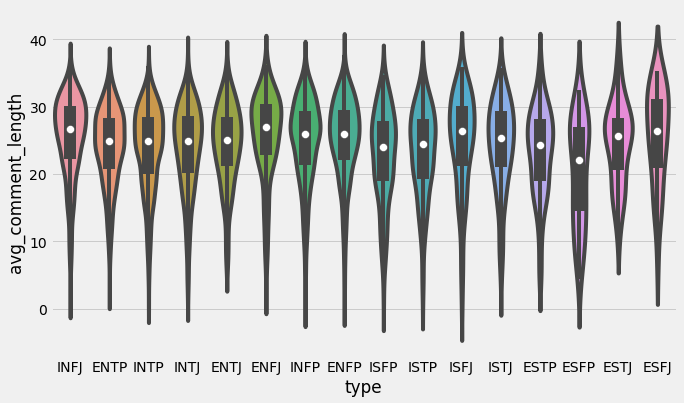

In [12]:
plt.figure(figsize=(10,6))
sns.violinplot(x='type', y='avg_comment_length', data=mbti)

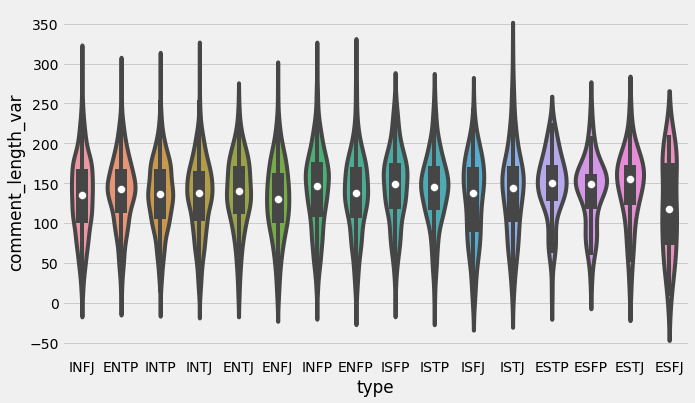

In [13]:
plt.figure(figsize=(10,6))
sns.violinplot(x='type', y='comment_length_var', data=mbti)

## Data preprocessing

### Define a function for cleaning the posts:
- Remove "|||" and links and punctuations and MBTI words(As u see in the text, real names user referring to are changed to MBTI type)
- Lowercase
- Lemmatize word, remove stop words and words less than 3 characters (lemmatizing would be better than stemming but takes more time)

In [14]:
# get 16 types of personality list for removing MBTI words in the following function
types = list(mbti.iloc[:,0].unique())
types = [t.lower() for t in types]

# A type consists of 4 capitals and each capital corresponds to 2 possible characteristics.
# For later encoding and modeling issues, let's tranfer them into separate binary code.
type_map = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}

In [15]:
def post_preprocess(df):
    i = 0
    post_list = []
    length = len(df)
    lemmatiser = WordNetLemmatizer() # or use PorterStemmer(), if want to run faster
    print('Processing... Be patient')
    
    for row in df.iterrows():
        # Progress bar
        i+=1
        if (i % 500 == 0 or i == length):
            print(f"Progress bar：{round(i/length*100)}%")
        # clean the posts
        posts = row[1].posts
        posts = re.sub(r'\|\|\|',' ',posts)
        posts = re.sub(r'http[\S]*', '', posts).lower()
        posts = re.sub("[^a-z\s]", ' ', posts)
        posts = ' '.join([lemmatiser.lemmatize(w) for w in posts.split(' ') if w not in stopwords.words('english')])
        for t in types:
            posts = posts.replace(t,'')
        post_list.append(posts)
        
    return np.array(post_list)      

In [21]:
# Here I takes 15mins to run it T_T
processed_post = post_preprocess(mbti)

Processing... Be patient
Progress bar：6%
Progress bar：12%
Progress bar：17%
Progress bar：23%
Progress bar：29%
Progress bar：35%
Progress bar：40%
Progress bar：46%
Progress bar：52%
Progress bar：58%
Progress bar：63%
Progress bar：69%
Progress bar：75%
Progress bar：81%
Progress bar：86%
Progress bar：92%
Progress bar：98%
Progress bar：100%


In [24]:
# randomly pick one to check, as we use lemmatiser, the words look normal
processed_post[7]

' tend build collection thing desktop use frequently move folder called   everything  get sorted type sub type ike collect odd object  even work   lot people would call junk like collect   old unused software  ill take hand    bunch old adobe    think quite normal  tend see friend real life every couple month  said earlier people dont get good one     edit  mostly mean tolerate    go sleep  dreaming another form awake  many layer    thought sleep keep night  edit  sometimes im scared    thanks wish free follow interest desired  feel though wish meant impossible thing seeing mean visual interpreting seeing mentally understanding concept  hello feel though incapable creating anything   wish could cant stand interviewer christ laugh       hmmm  would interesting see  show  doubt would interesting general public though     know think fi fe sound like   one think sound like   require input others know  question  s lean towards alternative rock type music      answer  well  went page sorted 

### Word Cloud

In [55]:
# for convience, we need processed_post and types occurring in the same df.
mbti['processed_post'] = processed_post

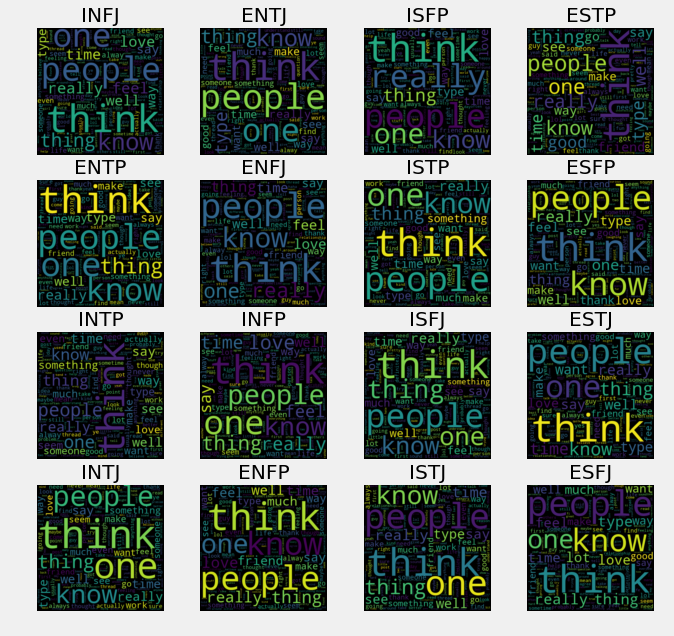

In [70]:
dim = int(len(mbti['type'].unique())**0.5)
fig, ax = plt.subplots(nrows=dim, ncols=dim, figsize=(10, 10))
j = 0
for i, mbti_type in enumerate(mbti['type'].unique()):
    if i % dim == 0 and i != 0:
        j += 1
    posts = [user_posts for user_posts in mbti[mbti['type'] == mbti_type]['processed_post']]
    cloud = WordCloud(height=400).generate(" ".join(posts))
    ax[i%dim,j].imshow(cloud, interpolation='bilinear')
    ax[i%dim,j].axis("off")
    ax[i%dim,j].set_title(mbti_type)

In [75]:
mbti.drop('processed_post',axis=1,inplace=True)

Might need to remove words like think, people, know, thing later to make it intuitive. To be continue...

### Define a function to transfer the types? (Maybe useful for modeling)

In [17]:
# transfer column 3-6 into binary code.
def type_preprocess(df):
    ty_bin = df.iloc[:,2:6]
    col = ty_bin.columns
    for i in range(len(col)):
        ty_bin.iloc[:,i] = ty_bin.iloc[:,i].map(type_map)
    return ty_bin

In [18]:
processed_type = type_preprocess(mbti)

In [20]:
processed_type.head()

,EorI,NorS,TorF,JorP
0,0,0,0,0
1,1,0,1,1
2,0,0,1,1
3,0,0,1,0
4,1,0,1,0


### Posts Vectorized

Create a bag of words representation of each user by using tfidf

In [53]:
# Chose TfidfVectorizer with min_df = 25 because there were some odd cases like 'aaaaa' 
# max_df=.8 to filter common words. Max_features to set limit for the length of each vector
# here I take 5000 just compare to Ben's 7857, 5000 means 5000 words with higher frequency among words. 
# I don't dare to filter out some word less than 3 characters 
# since there are some acronym or words like 'aha' which may contain positive info.
vectorizer = TfidfVectorizer(max_df=.8, min_df=25, max_features=5000)
word_count = vectorizer.fit_transform(processed_post)
# Create word_count dataframe 
word_count_df = pd.DataFrame(data = word_count.toarray(), columns = vectorizer.get_feature_names())
word_count_df.head()

,abandon,abandoned,ability,able,abnormal,abortion,abroad,absence,absent,absolute,...,youth,youtube,yr,yup,zelda,zen,zero,zodiac,zombie,zone
0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.070881,0.000000,0.027505,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.088966,0.032256,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.059444,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.058288,0.0,0.0,0.0,0.0,0.0,0.054109,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Sentiment Score 

**Caution:** Takes a few minutes to run

In [38]:
analyzer = SentimentIntensityAnalyzer()
scores = []
length_p = len(processed_post)
for i in range(length_p):
    score = analyzer.polarity_scores(processed_post[i])['compound']
    scores.append(score)
    # Print Progress 
    if (i % 500 == 0 or i == length_p-1):
            print(f"Progress bar：{round(i/length_p*100)}%")

Progress bar：0%
Progress bar：6%
Progress bar：12%
Progress bar：17%
Progress bar：23%
Progress bar：29%
Progress bar：35%
Progress bar：40%
Progress bar：46%
Progress bar：52%
Progress bar：58%
Progress bar：63%
Progress bar：69%
Progress bar：75%
Progress bar：81%
Progress bar：86%
Progress bar：92%
Progress bar：98%


In [39]:
pd.Series(scores).describe()

count    8675.000000
mean        0.944838
std         0.291555
min        -0.999500
25%         0.996700
50%         0.998700
75%         0.999400
max         1.000000
dtype: float64

I am really curious about the guy with -0.999500 

### Ellipses Count

Counting number of ellipsies used per user.

In [41]:
# Create a list of ellpsies count per user. This is an indicator for long posts 
ellipses_count = [len(re.findall(r'\.\.\.',posts)) for posts in mbti['posts']]
# Append to dataset 
mbti['ellipses'] = ellipses_count

### Exclamation Count
Counting number of exclamation marks used per user. 

In [42]:
# Create a list of exclamation count per user. 
exclamation_count = [len(re.findall(r'!',posts)) for posts in mbti['posts']]
# Append to dataframe
mbti['exclamation'] = exclamation_count

### Question Count
Counting number of question marks used per user. 

In [45]:
# Create a list of question count per user. 
question_count = [len(re.findall(r'\?',posts)) for posts in mbti['posts']]
# Append to dataframe
mbti['question'] = question_count

### Link Count 
Counting number of links used per user. 

In [46]:
# For each user, remove ||| to make it easier to find links. 
user_posts = [re.sub(r'\|\|\|',' ',posts) for posts in mbti['posts']]
# Create a list of link count per user. 
link_count = [len(re.findall(r'http[\S]* ', posts)) for posts in user_posts]
# Append to dataframe
mbti['links'] = link_count

### Picture Count

In [51]:
# Create a list of question count per user. 
question_count = [len(re.findall(r'(\.png)|(\.jpg)',posts)) for posts in mbti['posts']]
# Append to dataframe
mbti['picture'] = question_count

### Emojies Count
We should probably modify the text_style_emojies to include more.

In [71]:
def find_emoji(text):
    # REMOVE LATER ON
    text = text.lower()
    
    text = re.sub(r'\|\|\|', ' ', text)
    
    slack_style_emojies = re.findall(r':[\w\d]+(\-[\w\d]+)?:', text)
    text_style_emojies = re.findall(r':[\-|\s]?[d|\)|\(|p]', text)
    
    return slack_style_emojies + text_style_emojies

In [76]:
mbti['emojies'] = mbti['posts'].map(lambda x: len(find_emoji(x)))

In [77]:
mbti.head()

,type,posts,EorI,NorS,TorF,JorP,avg_comment_length,comment_length_var,ellipses,exclamation,question,links,picture,emojies
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J,11.12,135.2900,15,3,18,24,6,4
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P,23.40,187.4756,19,0,5,9,8,14
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P,16.72,180.6900,13,4,12,4,0,10
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J,21.28,181.8324,26,3,11,2,0,0
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J,19.34,196.4576,21,1,10,6,2,1


### Additional things to Consider:

* N grams (or is this more of a step tuning with count vectorizer? 

I think we can adjust this parameter when modeling
* About modeling: Which one is better? Training models for predicting EI,NS,TF,JP or just predicting type?